# A First Adjoint Example

In this example we will explore leveraging an adjoint formulation of the linear Boltzmann equations for computing response functions in a desired region of interest (RoI).

The following is a complete transport simulation example. Each element of the simulation can be described in the sections below:
- [Prerequisites](#prerequisites)
- [Mesh](#mesh)
- [Geometry](#Geometry)
    - [Material IDs](#material-ids)
    - [Cross Sections](#cross-sections)
- [Solver](#Solver)
    - [Angular Quadrature](#angular-quadrature)
    - [Group Structure](#group-structure)
    - [Discrete Ordinates Problem](#discrete-ordinates-problem)
    - [Execute](#execute)
    - [Post Processing](#post-processing)
        - [Volumetric Field Function](#volumetric-field-function)
        - [Linear Field Function](#linear-field-function)
- [Adjoint Solver](#adjoint-solver)
    - [Adjoint Source](#adjoint-source)
    - [Adjoint Options](#adjoint-options)
    - [Post Processing](#post-processing)
        - [Detector Response](#detector-response)
        - [Linear Field Function](#linear-field-function)
- [Solution](#solution)


---

## Prerequisites

Before running this example, make sure that the **Python module of OpenSn** was installed.

### Converting and Running this Notebook from the Terminal
To run this notebook from the terminal, simply type:

`jupyter nbconvert --to python --execute adjoint_example.ipynb`.

To run this notebook in parallel (for example, using 4 processes), simply type:

`mpiexec -n 4 jupyter nbconvert --to python --execute adjoint_example.ipynb`.

In [1]:
from mpi4py import MPI
size = MPI.COMM_WORLD.size
rank = MPI.COMM_WORLD.rank
barrier = MPI.COMM_WORLD.barrier

if rank == 0:
    print(f"Running the first LBS adjoint example with {size} MPI processors.")

Running the first LBS adjoint example with 1 MPI processors.


### Import Requirements

Import required classes and functions from the Python interface of OpenSn. Make sure that the path
to PyOpenSn is appended to Python's PATH.

In [2]:
import os
import sys
import numpy as np

# assuming that the execute dir is the notebook dir
# this line is not necessary when PyOpenSn is installed using pip
sys.path.append("../../..")

from pyopensn.mesh import OrthogonalMeshGenerator
from pyopensn.xs import MultiGroupXS
from pyopensn.source import PointSource, VolumetricSource
from pyopensn.aquad import GLProductQuadrature1DSlab
from pyopensn.solver import DiscreteOrdinatesProblem, SteadyStateSourceSolver
from pyopensn.response import ResponseEvaluator
from pyopensn.math import Vector3
from pyopensn.fieldfunc import FieldFunctionInterpolationVolume, \
                               FieldFunctionInterpolationLine, \
                               FieldFunctionGridBased
from pyopensn.logvol import RPPLogicalVolume
from pyopensn.context import UseColor, Finalize

OpenSn version 0.0.1
2025-09-20 02:04:31 Running OpenSn with 1 processes.



---

## Mesh
Here, we will use the in-house orthogonal mesh generator for a simple Cartesian grid. We first create a list of nodes in the Z direction.

In [3]:
N = 1000
L = 10.0
ds = L / N
nodesz = []
for i in range(N + 1):
    nodesz.append(i * ds)

### Orthogonal Mesh Generation
We use the `OrthogonalMeshGenerator` and pass the list of nodes per dimension. Here, we pass our lsit of nodes for the z direction creating a 1D geometry of side length 10 cm with 100 square cells. 

In [4]:
meshgen = OrthogonalMeshGenerator( node_sets=[nodesz] )
grid = meshgen.Execute()

[0]  Done checking cell-center-to-face orientations
[0]  00:00:00.2 Establishing cell connectivity.
[0]  00:00:00.2 Vertex cell subscriptions complete.
[0]  00:00:00.2 Surpassing cell 100 of 1000 (10%)
[0]  00:00:00.2 Surpassing cell 200 of 1000 (20%)
[0]  00:00:00.2 Surpassing cell 301 of 1000 (30%)
[0]  00:00:00.2 Surpassing cell 400 of 1000 (40%)
[0]  00:00:00.2 Surpassing cell 500 of 1000 (50%)
[0]  00:00:00.2 Surpassing cell 601 of 1000 (60%)
[0]  00:00:00.2 Surpassing cell 701 of 1000 (70%)
[0]  00:00:00.2 Surpassing cell 800 of 1000 (80%)
[0]  00:00:00.2 Surpassing cell 900 of 1000 (90%)
[0]  00:00:00.2 Surpassing cell 1000 of 1000 (100%)
[0]  00:00:00.2 Establishing cell boundary connectivity.
[0]  00:00:00.2 Done establishing cell connectivity.
[0]  Number of cells per partition (max,min,avg) = 1000,1000,1000
[0]  
[0]  Mesh statistics:
[0]    Global cell count             : 1000
[0]    Local cell count (avg,max,min): 1000,1000,1000
[0]    Ghost-to-local ratio (avg)    : 0
[0]

---

## **Geometry**
### Material IDs
In this example, we define a source-driven detector response problem consisting of two regions: a detector and a source in vacuum. The geometry of the model is shown below.

<img src="images/adjoint_geom.png"/>

Firstly, when using the in-house `OrthogonalMeshGenerator`, no material IDs are assigned. The user needs to assign material IDs to all cells. We will begin by assigning the background material ID with a value of 0.

In [5]:
grid.SetUniformBlockID(0)

[0]  00:00:00.3 Done setting block id 0 to all cells


Next we will assign material IDs for the source and detector. When assigning material IDs via logical volumes the IDs for each cell is overriden by the most recent assignment. That is to say, assigning a material ID of 1 to any region in our domain will override the previously set ID to those cells. 

In [6]:
source = RPPLogicalVolume(
            infx=True,
            infy=True,
            zmin=2.0, zmax=4.0,
)
grid.SetBlockIDFromLogicalVolume(source, 1, True)

det = RPPLogicalVolume(
            infx=True,
            infy=True,
            zmin=7.75, zmax=8.25,
)
grid.SetBlockIDFromLogicalVolume(det, 2, True)

### Cross Sections
We generate one-group cross sections using OpenSn’s `CreateSimpleOneGroup` method. In this tutorial, the background is set to vacuum. For the source region, we assign a total cross section $\Sigma_t = 1.0$ with a scattering ratio $c = \frac{\Sigma_{s,0}}{\Sigma_t} = 1.0$, making it a pure scatterer. The detector region is given a total cross section $\Sigma_t = 0.6$ and a scattering ratio of 0.0, making it a pure absorber.

In [7]:
xs_bkgrnd = MultiGroupXS()
xs_bkgrnd.CreateSimpleOneGroup(sigma_t=0.0, c=0.0)

xs_src = MultiGroupXS()
xs_src.CreateSimpleOneGroup(sigma_t=1.0, c=1.0)

sig_det = 0.6
xs_det = MultiGroupXS()
xs_det.CreateSimpleOneGroup(sigma_t=sig_det, c=0.0)

xsecs = [{"block_ids": [0], "xs": xs_bkgrnd},
         {"block_ids": [1], "xs": xs_src},
         {"block_ids": [2], "xs": xs_det}]

[0]  *** WARNING ***  Negative transport cross section found for group 0 in call to ComputeDiffusionParameters. sigma_t=0 sigma_1=0. Setting sigma_1=0, sigma_tr=sigma_t for this group.


---

## Solver

### Angular Quadrature
Since we are solving a 1D problem we will create Gauss-Legendre Product Quadrature for a 1D slab. In this case we will use 512 polar angles creating a 1D angular quadrature in $\mu$ with a scattering order of 0.

In [8]:
pquad = GLProductQuadrature1DSlab(n_polar=512, 
                                  scattering_order=0)

[0]  Using 1D Slab Gauss–Legendre product quadrature with 512 angles and weight sum of 1.00


### Group Structure

In [9]:
num_groups = 1
grpsets = [
    {
        "groups_from_to": (0, num_groups-1),
        "angular_quadrature": pquad,
        "inner_linear_method": "petsc_gmres",
        "l_abs_tol": 1.0e-6,
        "l_max_its": 300,
        "gmres_restart_interval": 100,
    },
]

### Volumetric Source
For the volumetric source, we assign a source strength of 1.0 per unit length to material ID 1. 

In [10]:
Q = 1.0
dL = 2.0
vol_src = VolumetricSource(block_ids=[1], group_strength=[Q/dL])

### Discrete Ordinates Problem
For establishing the discrete ordinate problem, we provide;
+ mesh : The mesh
+ num_groups : The number of energy groups
+ groupsets : The groupsets block
+ xs_map : Cross section map
+ volumetric_sources : The volumetric source
+ boundary_conditions : The boundary conditions

**Note: The parameters for the `DiscreteOrdinatesProblem` are not required to be in this order.**

In [11]:
phys = DiscreteOrdinatesProblem(
    mesh=grid,
    num_groups=num_groups,
    groupsets=grpsets,
    xs_map=xsecs,
    volumetric_sources = [vol_src],
    boundary_conditions=[
        {"name": "zmin", "type": "vacuum"},
        {"name": "zmax", "type": "vacuum"}
    ],
)

### Execute
We then create the physics solver, initialize it, and execute it.

In [12]:
ss_solver = SteadyStateSourceSolver(problem=phys)
ss_solver.Initialize()

[0]  
[0]  Initializing LBS SteadyStateSourceSolver with name: LBSDiscreteOrdinatesProblem
[0]  
[0]  Scattering order    : 0
[0]  Number of Groups    : 1
[0]  Number of Group sets: 1
[0]  
[0]  ***** Groupset 0 *****
[0]  Groups:
[0]      0 
[0]  
[0]  Initializing spatial discretization.
[0]  Computing unit integrals.
[0]  Ghost cell unit cell-matrix ratio: 0%
[0]  Cell matrices computed.
[0]  Initializing parallel arrays. G=1 M=1
[0]  Done with parallel arrays.
[0]  Volumetric source #0 has 200 total subscribing cells.
[0]  00:00:00.7 Initializing sweep datastructures.
[0]  00:00:00.7 Done initializing sweep datastructures.
[0]  00:00:00.7 Initialized angle aggregation.
[0]  Initializing WGS and AGS solvers


Note: In this tutorial we have decided to execute the linear Boltzmann solver in addition to the adjoint solver to illustrate their duality. It is not necessary to execute the standard linear Boltzmann solver to use the adjoint solver. 

In [13]:
ss_solver.Execute()

[0]  Total number of angular unknowns: 1024000
[0]  Number of lagged angular unknowns: 0(0%)
[0]  
[0]  
[0]  ********** Solving groupset 0 with PETSC_GMRES
[0]  
[0]  Quadrature number of angles: 512
[0]  Groups 0 0
[0]  
[0]  00:00:00.7 Computing b
[0]  00:00:00.8 WGS groups [0-0] Iteration     0 Residual         1
[0]  00:00:00.8 WGS groups [0-0] Iteration     1 Residual   0.17567
[0]  00:00:00.9 WGS groups [0-0] Iteration     2 Residual 0.0127995
[0]  00:00:00.9 WGS groups [0-0] Iteration     3 Residual 0.000713653
[0]  00:00:01.0 WGS groups [0-0] Iteration     4 Residual 3.29238e-05
[0]  00:00:01.1 WGS groups [0-0] Iteration     5 Residual 1.29272e-06
[0]  00:00:01.1 WGS groups [0-0] Iteration     6 Residual 4.406e-08 CONVERGED
[0]  
[0]  
[0]         Average sweep time (s):        0.05656
[0]         Sweep Time/Unknown (ns):       55.2343
[0]         Number of unknowns per sweep:  1024000
[0]  


### Post Processing
#### Volumetric Field Function

With the solver executed, we now create a `FieldFunction`. In OpenSn we define a `FieldFunction` for the response we will like to calculate. In this case we are looking to compute the total $He^3$ absorption reaction rate in our detector: 

$$
\text{QoI} = \text{RR}(\mathcal{D}) = \int_\mathcal{D} d^3r \, \int_{(4\pi)} d\Omega \, \sigma_{det}(\vec{r}) \psi(\vec{r},\vec\Omega)  = \int_\mathcal{D} d^3r \, \sigma_{det}(\vec{r}) \phi(\vec{r}) 
$$

Thus, in OpenSn we will generate a scalar field function using `GetScalarFluxFieldFunction` with a `sum` over the RoI. 

In [14]:
fflist = phys.GetScalarFluxFieldFunction(only_scalar_flux=True)
ffvol = FieldFunctionInterpolationVolume()
ffvol.SetOperationType("sum")
ffvol.SetLogicalVolume(det)
ffvol.AddFieldFunction(fflist[0])
ffvol.Initialize()
ffvol.Execute()

fwd_flux = ffvol.GetValue()
fwd_resp = sig_det*fwd_flux

if rank == 0:
    print(f"Forward Total Flux : {fwd_flux:.6e}")
    print(f"Forward Total Response : {fwd_resp:.6e}")


Forward Total Flux : 3.321548e-01
Forward Total Response : 1.992929e-01


We can also export the scalar flux, $\phi(x)$, to a .vtu file using ``ExportMultipleToPVTU``.

In [15]:
FFGrid = FieldFunctionGridBased
FFGrid.ExportMultipleToPVTU([fflist[0]], "Flux/fwdflux_p")

[0]  Exporting field functions to PVTU with file base "Flux/fwdflux_p"
[0]  Done exporting field functions to PVTU.


### Linear Field Function
To save the scalar flux along a line segment of the problem we use `FieldFunctionInterpolationLine()`. 

In [16]:
for g in range(num_groups):
    # Linear Field Function
    ffline = FieldFunctionInterpolationLine()
    ffline.SetInitialPoint(Vector3(0.0, 0.0, 0.0))
    ffline.SetFinalPoint(Vector3(0.0, 0.0, 10.0))
    ffline.SetNumberOfPoints(1000)
    ffline.AddFieldFunction(fflist[0])
    ffline.Initialize()
    ffline.Execute()
    ffline.ExportToCSV("Flux/detector")

[0]  Exported CSV file for field func "phi_g000_m00" to "Flux/detector_phi_g000_m00.csv"


---

## Adjoint Solver
### Adjoint Source

To solve the 1D detector response using the adjoint operator, we begin by defining the adjoint source $q^{\dagger}$ over the detector volume with a source strength of 1.0. By default, adjoint sources are distributed isotropically in angle across the source domain.

In [17]:
adj_src = VolumetricSource(logical_volume=det, group_strength=[1.0])

### Adjoint Options 
For executing the adjoint solver there are two options we must re-assign;
+ A toggle for the adjoint, default is False.
+ Updating the volumetric sources.

Note: Once the adjoint data has been saved locally you do not need to run `Execute` to run the response evaluator. Pay close attention to the `ResponseEvaluator`.

In [18]:
phys.SetOptions(adjoint = True)
phys.SetVolumetricSources(clear_volumetric_sources = True)
phys.SetVolumetricSources(volumetric_sources = [adj_src]) 
ss_solver.Execute()

[0]  Volumetric source #1 has 50 total subscribing cells.
[0]  
[0]  
[0]  ********** Solving groupset 0 with PETSC_GMRES
[0]  
[0]  Quadrature number of angles: 512
[0]  Groups 0 0
[0]  
[0]  00:00:01.3 Computing b
[0]  00:00:01.4 WGS groups [0-0] Iteration     0 Residual         1
[0]  00:00:01.4 WGS groups [0-0] Iteration     1 Residual  0.106629
[0]  00:00:01.5 WGS groups [0-0] Iteration     2 Residual 0.0450525
[0]  00:00:01.5 WGS groups [0-0] Iteration     3 Residual 0.0184022
[0]  00:00:01.6 WGS groups [0-0] Iteration     4 Residual 0.00336001
[0]  00:00:01.7 WGS groups [0-0] Iteration     5 Residual 0.000388187
[0]  00:00:01.7 WGS groups [0-0] Iteration     6 Residual 3.50983e-05
[0]  00:00:01.8 WGS groups [0-0] Iteration     7 Residual 2.65622e-06
[0]  00:00:01.8 WGS groups [0-0] Iteration     8 Residual 1.73704e-07 CONVERGED
[0]  
[0]  
[0]         Average sweep time (s):        0.0584055
[0]         Sweep Time/Unknown (ns):       57.0367
[0]         Number of unknowns per sw

### Post Processing
#### Detector Response

When evaluating response functions via the adjoint its efficiency derives from having access to the adjoint solution $\phi^{\dagger}$. For this, we export the adjoint flux moments to a .h5 file using `WriteFluxMoments`. The adjoint data is then saved to a location of our choosing.  

In [19]:
data_dir = os.getcwd()+"/Data"
os.makedirs(data_dir, exist_ok=True)
    
phys.WriteFluxMoments(data_dir+"/adjflux_p")

[0]  Writing flux moments to /home/jason/Documents/Work/OpenSn/opensn-jay/doc/source/tutorials/lbs/primer/Data/adjflux_p


With the adjoint data in hand and a forward source defined, we now create a `ResponseEvaluator`. 

We supply two options to the `evaluator`; the `buffers` (adjoint data) and the `sources`.

In [20]:
fwd_src = {'material': [{'block_id': 1, 'strength': [Q/dL]}]}

evaluator = ResponseEvaluator(problem = phys)
evaluator.SetOptions(
    buffers = [{
        'name': 'detector',
        'file_prefixes': {'flux_moments': data_dir+'/adjflux_p'}
    }],
    sources = fwd_src
)

[0]  Reading flux moments from /home/jason/Documents/Work/OpenSn/opensn-jay/doc/source/tutorials/lbs/primer/Data/adjflux_p


For computing the detector response we make use of `EvaluateResponse` which given a buffer name will compute an inner product of the adjoint flux $\phi^{\dagger,}$ against the forward source $q$ using the [duality principle](../../../theory/adjoint.rst) such that:

$$
\text{QoI} = \int_\mathcal{D} d^3r \, \int_{(4\pi)}   d\Omega  \, q(\vec{r},\vec\Omega) \psi^{\dagger}(\vec{r},\vec\Omega) = \int_\mathcal{D}  d^3r  \, q(\vec{r}) \phi^{\dagger}(\vec{r})
$$  

In [21]:
adj_flux = evaluator.EvaluateResponse("detector")
adj_resp = sig_det*adj_flux


if rank == 0:
    print(f"{'Adjoint Total Flux :'} {adj_flux:.6e}")
    print(f"{'Adjoint Total Response :'} {adj_resp:.6e}")

Adjoint Total Flux : 3.321548e-01
Adjoint Total Response : 1.992929e-01


The adjoint flux solution can be exported to a .vtu using `ExportMultiToPVTU`, the same method previously used for the "forward" flux. 

In [22]:
fflist = phys.GetScalarFluxFieldFunction(only_scalar_flux=True)
FFGrid = FieldFunctionGridBased
FFGrid.ExportMultipleToPVTU([fflist[0]], "Flux/adjflux_p")

[0]  Exporting field functions to PVTU with file base "Flux/adjflux_p"
[0]  Done exporting field functions to PVTU.


#### Linear Field Function
To save the scalar flux along a line segment of the problem we once again use ``FieldFunctionInterpolationLine()``

In [23]:
for g in range(num_groups):
    # Linear Field Function
    ffline = FieldFunctionInterpolationLine()
    ffline.SetInitialPoint(Vector3(0.0, 0.0, 0.0))
    ffline.SetFinalPoint(Vector3(0.0, 0.0, 10.0))
    ffline.SetNumberOfPoints(1000)
    ffline.AddFieldFunction(fflist[0])
    ffline.Initialize()
    ffline.Execute()
    ffline.ExportToCSV("Flux/adjdetector")

[0]  Exported CSV file for field func "phi_g000_m00" to "Flux/adjdetector_phi_g000_m00.csv"


---

## Solution

To plot the scalar flux $\phi(z)$ and adjoint flux $\phi^\dagger(z)$ we load the respective data from the .csv files. 

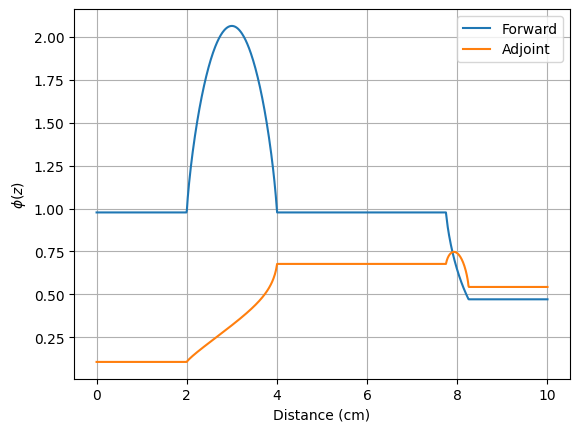

In [24]:
import csv
from os import walk
import matplotlib.pyplot as plt

# Convert each CSV to a python dictionary
def CSVToDict(filename):
    data = {}
    with open(filename, newline="") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            for key, value in row.items():
                data.setdefault(key, []).append(float(value))
    return data

# Collect each flux distribution into a dictionary
# Flux -> detector   -> {x,y,z,phi_g001_m00}
#      -> adjdetector -> {x,y,z,phi_g002_m00}
Flux = {}
for (dirpath, dirnames, filenames) in walk('Flux/'):
   for filename in filenames:
        if filename.split(".")[1] == "csv":
            key = filename.split('.')[0].split('_')[0]
            Flux[key] = CSVToDict("Flux/"+filename)

z = Flux['detector']['z']
fwd = Flux['detector']['phi_g000_m00']
adj = Flux['adjdetector']['phi_g000_m00']

plt.figure()
plt.plot(z, fwd, label="Forward")
plt.plot(z, adj, label="Adjoint")
plt.xlabel("Distance (cm)")
plt.ylabel(r"$\phi(z)$")
plt.legend()
plt.grid()
plt.show()

---

## Finalize (for Jupyter Notebook only)

In Python script mode, PyOpenSn automatically handles environment termination. However, this
automatic finalization does not occur when running in a Jupyter notebook, so explicit finalization
of the environment at the end of the notebook is required. Do not call the finalization in Python
script mode, or in console mode.

Note that PyOpenSn's finalization must be called before MPI's finalization.


In [25]:
from IPython import get_ipython

def finalize_env():
    Finalize()
    MPI.Finalize()

ipython_instance = get_ipython()
if ipython_instance is not None:
    ipython_instance.events.register("post_execute", finalize_env)

os.system("rm -rf Data Flux AdjFlux")


0


Elapsed execution time: 00:00:02.8
2025-09-20 02:04:34 OpenSn finished execution.
